# Assignment 3: Word Prediction
#### Ido Rozenzon 318320017

In this assignment, we will make a neural network that can predict the next word
in a sentence given the previous three.  
In doing this prediction task, our neural networks will learn about *words* and about how to represent words. We'll explore the *vector representations* of words that our model produces, and analyze these representations.

**Submission**: When you are finished with the assignment make sure you submit the following files:

1. This file (ML_DL_Assignment3.ipynb) compressed to zip(submit ML_DL_Assignment3.zip).
2. The functions file (ML_DL_Functions3.py).
3. The parameters for the first model from section 2.5 ('MLP_model.pk').
4. The parameters for the second model from section 3.3 ('emb_MLP_model.pk').

**grading**: In this assignment, you will be graded according to the implementation and performance of all the functions in the functions file and the accuracy of your trained models. Make sure to check that each function accepts and returns any type and shape required from it in the functions file.

In [126]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import collections

import torch
import torch.nn as nn
import torch.optim as optim
import sys
def reload_functions():
  if 'ML_DL_Functions3' in sys.modules:
    del sys.modules['ML_DL_Functions3']
  functions_path = drive_path.replace(" ","\ ") + 'ML_DL_Functions3.py'
  !cp $functions_path .

## Question 1. Data

With any machine learning problem, the first thing that we would want to do
is to get an intuitive understanding of what our data looks like. Download the file
`raw_sentences.txt` from the course page on Moodle and upload it to Google Drive.
Then, mount Google Drive from your Google Colab notebook:

In [127]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Find the path to `raw_sentences.txt`:

In [128]:
drive_path = '/content/gdrive/My Drive/NotabilityG24/Intro_to_ML/Assignment3/' # TODO - UPDATE ME!(raw_sentences.txt should be in this path)
sentences_path = drive_path+'raw_sentences.txt'

The following code reads the sentences in our file, split each sentence into
its individual words, and stores the sentences (list of words) in the
variable `sentences`.

In [129]:
sentences = []
for line in open(sentences_path):
    words = line.split()
    sentence = [word.lower() for word in words]
    sentences.append(sentence)

There are 97,162 sentences in total, and
these sentences are composed of 250 distinct words.

In [130]:
vocab = set([w for s in sentences for w in s])
print(len(sentences)) # 92162
print(len(vocab)) # 250

92162
250


We'll separate our data into training, validation, and test.
We'll use `5,000 sentences for test, 10,000 for validation, and
the rest for training.

In [131]:
test, valid, train = sentences[:5000], sentences[5000:15000], sentences[15000:]

### 1.1 Learning the data

**Display** 10 sentences in the training set.


In [132]:
#Write your code here
train[950:960]

[['and', 'she', 'said', 'she', 'could', 'nt', '.'],
 ['they', 'have', 'to', 'put', 'them', 'to', 'work', '.'],
 ['she', 'would', 'just', 'not', 'do', 'that', '.'],
 ['what', 'is', 'it', 'they', 'say', '?'],
 ['it', 'will', 'never', 'work', '.'],
 ['what', 'can', 'i', 'do', 'about', 'it', '?'],
 ['what', 'are', 'you', 'going', 'to', 'do', 'with', 'me', '?'],
 ['i',
  'says',
  ',',
  'i',
  'do',
  'nt',
  'want',
  'to',
  'take',
  'it',
  'no',
  'more',
  '.'],
 ['so', 'there', 'was', 'nt', 'much', 'time', '.'],
 ['it', "'s", 'too', 'much', 'money', 'to', 'think', 'about', '.']]

#### Food for thought
how are punctuations treated in our word representation? How are words
with apostrophes represented? Why is it done this way?

### 1.2 Most Common Words

**Print** the 10 most common words in the vocabulary and how often does each of these
words appear in the training sentences. Express the second quantity as a percentage
(i.e. number of occurences of the  word / total number of words in the training set).

These are useful quantities to compute, because one of the first things a machine learning model will learn is to predict the **most common** class. Getting a sense of the
distribution of our data will help you understand our model's behaviour.

You can use Python's `collections.Counter` class if you would like to.

In [133]:
# Your code goes here
from collections import Counter

# Flatten the list of training sentences into a single list of words
all_words = [word for sentence in train for word in sentence]

# Count the occurrences of each word
word_counts = Counter(all_words)

# Get the total number of words in the training set
total_words = sum(word_counts.values())

# Find the 10 most common words
most_common_words = word_counts.most_common(10)

# Display the words, their counts, and their percentages
print("Word\tCount\tPercentage")
for word, count in most_common_words:
    percentage = (count / total_words) * 100
    print(f"{word}\t{count}\t{percentage:.2f}%")


Word	Count	Percentage
.	64297	10.70%
it	23118	3.85%
,	19537	3.25%
i	17684	2.94%
do	16181	2.69%
to	15490	2.58%
nt	13009	2.16%
?	12881	2.14%
the	12583	2.09%
's	12552	2.09%


### 1.3 Generating the Dataset

Our neural network will take as input three words and predict the next one. Therefore, we need our data set to be comprised of seuqnces of four consecutive words in a sentence, referred to as *4grams*.

**Complete** the helper functions `convert_words_to_indices` and
`generate_4grams`, so that the function `process_data` will take a
list of sentences (i.e. list of list of words), and generate an
$N \times 4$ numpy matrix containing indices of 4 words that appear
next to each other, where $N$ is the number of 4grams (sequences of 4 words appearing one after the other) that can be found in the complete list of sentences. Examples of how these functions should operate are detailed in the functions file.

You can use the defined `vocab`, `vocab_itos`,
and `vocab_stoi` in your code.

In [134]:
reload_functions()
import ML_DL_Functions3
# A list of all the words in the data set. We will assign a unique
# identifier for each of these words.
vocab = sorted(list(set([w for s in train for w in s])))
# A mapping of index => word (string)
vocab_itos = dict(enumerate(vocab))
# A mapping of word => its index
vocab_stoi = {word:index for index, word in vocab_itos.items()}



def process_data(sents):
    """
    This function takes a list of sentences (list of lists), and generates an
    numpy matrix with shape [N, 4] containing indices of words in 4-grams.
    """
    indices = ML_DL_Functions3.convert_words_to_indices(sents,vocab_stoi)
    fourgrams = ML_DL_Functions3.generate_4grams(indices)
    return np.array(fourgrams)

# We can now generate our data which will be used to train and test the network
train4grams = process_data(train)
valid4grams = process_data(valid)
test4grams = process_data(test)

## Question 2. A Multi-Layer Perceptron

In this section, we will build a two-layer multi-layer perceptron.
Our model will look like this:

<img src="https://drive.google.com/uc?id=15uMLB-YsMHSOr0EQfTRhWd4o9enIOjUe">

Since the sentences in the data are comprised of $250$ distinct words, our task boils down to claissfication where the label space $\mathcal{S}$ is of cardinality $|\mathcal{S}|=250$ while our input, which is comprised of a combination of three words, is treated as a vector of size $750\times 1$ (i.e., the concatanation of three one-hot $250\times 1$ vectors).

The following function `get_batch` will take as input the whole dataset and output a single batch for the training. The output size of the batch is explained below.

**Implement** yourself the function `make_onehot` which takes the data in index notation and output it in a onehot notation.

Start by reviewing the helper function, which is given to you:

In [135]:
reload_functions()
import ML_DL_Functions3
# Complete the function make_onehot from the functions file
def get_batch(data, range_min, range_max, onehot=True):
    """
    Convert one batch of data in the form of 4-grams into input and output
    data and return the training data (xt, st) where:
     - `xt` is an numpy array of one-hot vectors of shape [batch_size, 3, 250]
     - `st` is either
            - a numpy array of shape [batch_size, 250] if onehot is True,
            - a numpy array of shape [batch_size] containing indicies otherwise

    Preconditions:
     - `data` is a numpy array of shape [N, 4] produced by a call
        to `process_data`
     - range_max > range_min
    """
    xt = data[range_min:range_max, :3]
    xt = ML_DL_Functions3.make_onehot(xt)
    st = data[range_min:range_max, 3]
    if onehot:
        st = ML_DL_Functions3.make_onehot(st).reshape(-1, 250)
    return xt, st
x,s = get_batch(train4grams, 0,32, onehot=False) # check that the output makes sense
print(x.shape)
print(s.shape)
print(s)
print(x)

(32, 3, 250)
(32,)
[ 87 168   3  55 102  71 121   6  96  57   9 102  79   9  51  57   9 169
 206   3 225  86  10 114 224 208  79   6 149 224   6  28]
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


### 2.1 MLP Model

We build the model in PyTorch. Since PyTorch uses automatic
differentiation, we only need to write the *forward pass* of our
model.

**Complete** the `forward` function in the PyTorchMLP class

In [136]:
# complete the forward function in PyTorchMLP

### 2.2 Training

We next  train the PyTorch model using the Adam optimizer and the cross entropy loss.

**Complete** the function `run_pytorch_gradient_descent`, and use it to train your PyTorch MLP model.

**Obtain** a training accuracy of at least 35% and a validation accuracy of at least 33% while changing only the hyperparameters of the train function.

Plot the learning curve using the `plot_learning_curve` function provided
to you.

In [137]:
# Do NOT change the code in this section. A similar function to this will be
# used to test your model.
def estimate_accuracy_torch(model, data, batch_size=5000, max_N=100000):
    """
    Estimate the accuracy of the model on the data. To reduce
    computation time, use at most `max_N` elements of `data` to
    produce the estimate.
    DO NOT EDIT THIS FUNCTION
    """
    correct = 0
    N = 0
    for i in range(0, data.shape[0], batch_size):
        # get a batch of data
        xt, st = get_batch(data, i, i + batch_size, onehot=False)

        # forward pass prediction
        y = model(torch.Tensor(xt))
        y = y.detach().numpy() # convert the PyTorch tensor => numpy array
        pred = np.argmax(y, axis=1)
        correct += np.sum(pred == st)
        N += st.shape[0]

        if N > max_N:
            break
    return correct / N

In [138]:
# The training function will not be tested directly(only through the resulting model)
# thus you can change it freely(change the function signature or any part within)
"""
    Train the PyTorch model on the dataset `train_data`, reporting
    the validation accuracy on `validation_data`, for `max_iters`
    iteration.

    If you want to **checkpoint** your model weights (i.e. save the
    model weights to Google Drive), then the parameter
    `checkpoint_path` should be a string path with `{}` to be replaced
    by the iteration count:

    For example, calling

    >>> run_pytorch_gradient_descent(model, ...,
            checkpoint_path = '/content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-{}.pk')

    will save the model parameters in Google Drive every 500 iterations.
    You will have to make sure that the path exists (i.e. you'll need to create
    the folder Intro_to_Deep_Learning, mlp, etc...). Your Google Drive will be populated with files:

    - /content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-500.pk
    - /content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-1000.pk
    - ...

    To load the weights at a later time, you can run:

    >>> model.load_state_dict(torch.load('/content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-500.pk'))

    This function returns the training loss, and the training/validation accuracy,
    which we can use to plot the learning curve.
    """
import torch
import torch.nn as nn
import torch.optim as optim

def run_pytorch_gradient_descent(model,
                                 train_data,
                                 validation_data,
                                 batch_size=100,
                                 learning_rate=0.001,
                                 weight_decay=0,
                                 max_iters=1000,
                                 checkpoint_path=None):
    """
    Train the PyTorch model on the dataset `train_data`, reporting
    the validation accuracy on `validation_data`, for `max_iters`
    iterations.

    Parameters:
    - model: The PyTorch model to train
    - train_data: Training data in the form of 4-grams
    - validation_data: Validation data in the form of 4-grams
    - batch_size: Size of each mini-batch
    - learning_rate: Learning rate for the optimizer
    - weight_decay: Weight decay (L2 regularization) for the optimizer
    - max_iters: Maximum number of training iterations
    - checkpoint_path: File path to save model checkpoints
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    if hasattr(model, "word_emb_layer"):
      scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.85)
    else:
      scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.85)
    iters, losses = [], []
    iters_sub, train_accs, val_accs = [], [], []

    n = 0  # iteration counter
    while True:
        for i in range(0, train_data.shape[0], batch_size):
            if (i + batch_size) > train_data.shape[0]:
                break

            # Get the input and target for the current batch
            xt, st = get_batch(train_data, i, i + batch_size, onehot=False)

            # Convert numpy arrays to PyTorch tensors
            xt = torch.Tensor(xt)
            st = torch.Tensor(st).long()

            # Compute predictions
            zs = model.forward(xt)

            # Compute the loss
            loss = criterion(zs, st)

            # Backward pass and parameter updates
            loss.backward()                    # compute updates for each parameter
            optimizer.step()                   # make the updates for each parameter
            optimizer.zero_grad()              # a clean up step for PyTorch

            # Save training information
            iters.append(n)
            losses.append(float(loss.sum()) / batch_size)  # Average loss

            # Every 500 iterations, report progress and save checkpoint
            if n % 500 == 0:
                scheduler.step()
                iters_sub.append(n)
                train_cost = float(loss.detach().numpy())
                train_acc = estimate_accuracy_torch(model, train_data)
                train_accs.append(train_acc)
                val_acc = estimate_accuracy_torch(model, validation_data)
                val_accs.append(val_acc)
                print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
                      n, val_acc * 100, train_acc * 100, train_cost))

                # Save model checkpoint
                if checkpoint_path is not None and n > 0:
                    torch.save(model.state_dict(), checkpoint_path.format(n))

            # Increment iteration counter
            n += 1

            # Stop if maximum iterations reached
            if n > max_iters:
                return iters, losses, iters_sub, train_accs, val_accs

def plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs, label="Train")
    plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Iter 0. [Val Acc 1%] [Train Acc 1%, Loss 5.524865]
Iter 500. [Val Acc 32%] [Train Acc 33%, Loss 2.929910]
Iter 1000. [Val Acc 34%] [Train Acc 35%, Loss 2.712241]
Iter 1500. [Val Acc 35%] [Train Acc 36%, Loss 2.749945]
Iter 2000. [Val Acc 35%] [Train Acc 37%, Loss 2.600840]


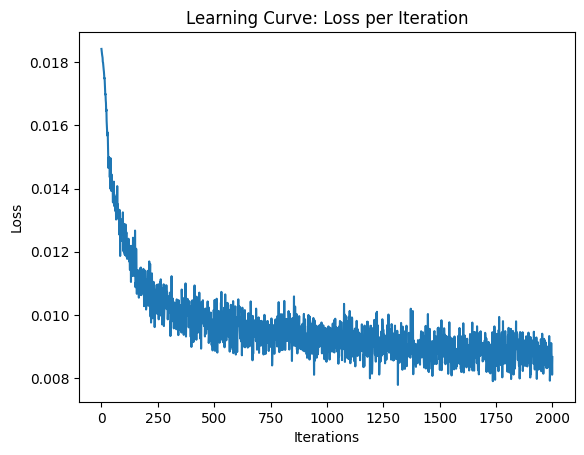

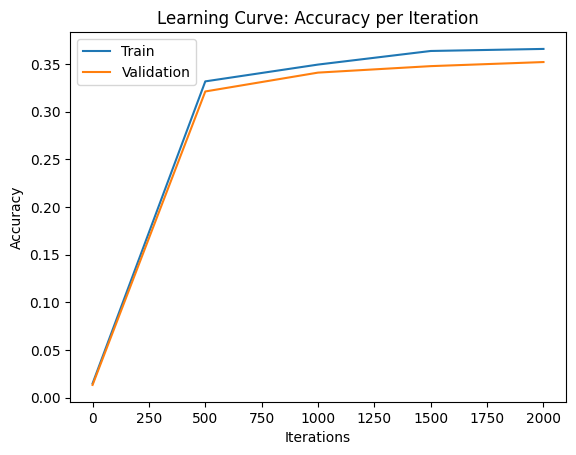

In [139]:
reload_functions()
import ML_DL_Functions3
pytorch_mlp = ML_DL_Functions3.PyTorchMLP()
learning_curve_info = run_pytorch_gradient_descent(
    pytorch_mlp,
    train_data=train4grams,            # Training 4-grams
    validation_data=valid4grams,      # Validation 4-grams
    batch_size=300,                   # Adjust batch size for better updates
    learning_rate=0.001,              # Experiment with learning rate for better convergence
    weight_decay=1e-6,                # Optional regularization
    max_iters=2000,                   # Enough iterations for accuracy improvement
    checkpoint_path="model_ckpt_{}.pth"  # Save checkpoints
)


plot_learning_curve(*learning_curve_info)

### 2.3 Making Predictions
**Write** a function `make_prediction` that takes as parameters
a PyTorchMLP model and sentence (a list of words), and produces
a prediction for the next word in the sentence.


In [140]:
reload_functions()
import ML_DL_Functions3
def make_prediction_torch(model, sentences):
    """
    Use the trained model to predict the next word in the sentences
    based on the last 3 words. Works for both one-hot encoded models
    and word embedding-based models.

    Args:
        model: Trained PyTorch model.
        sentences: Single sentence (list of words) or a batch of sentences (list of lists of words).

    Returns:
        List of predicted next words as strings (even if input is a single sentence).
    """
    global vocab_stoi, vocab_itos

    # If a single sentence is provided, wrap it in a list to make it a batch
    if isinstance(sentences[0], str):
        sentences = [sentences]  # Convert single sentence to a batch of one

    # Ensure all sentences have at least 3 words
    for sentence in sentences:
        if len(sentence) < 3:
            raise ValueError("Each input sentence must have at least 3 words.")

    # Extract the last 3 words from each sentence and convert to indices
    batch_last_three_indices = [
        [vocab_stoi[word] for word in sentence[-3:]] for sentence in sentences
    ]

    # Check if the model uses word embeddings
    if hasattr(model, "word_emb_layer"):
        # For PyTorchWordEmb model
        batch_size = len(sentences)
        vocab_size = len(vocab_stoi)

        # Create a one-hot encoded input tensor dynamically based on batch size
        input_tensor = torch.zeros(batch_size, 3, vocab_size)  # Shape: [batch_size, 3, vocab_size]
        for batch_idx, last_three_indices in enumerate(batch_last_three_indices):
            for word_idx, vocab_index in enumerate(last_three_indices):
                input_tensor[batch_idx, word_idx, vocab_index] = 1
    else:
        # For PyTorchMLP model
        batch_size = len(sentences)
        input_tensor = torch.zeros(batch_size, 750)  # Shape: [batch_size, 750]
        for batch_idx, last_three_indices in enumerate(batch_last_three_indices):
            for word_idx, vocab_index in enumerate(last_three_indices):
                input_tensor[batch_idx, word_idx * len(vocab_stoi) + vocab_index] = 1

    # Set the model to evaluation mode and make the prediction
    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)  # Forward pass to get logits

    # Find the indices of the predicted words for the entire batch
    predicted_indices = torch.argmax(logits, dim=1).tolist()

    # Convert the predicted indices back to corresponding words
    predicted_words = [vocab_itos[index] for index in predicted_indices]

    return predicted_words



### 2.4 A Few Examples

Use your code to predict what the next word should be in each
of the following sentences:

- "You are a"
- "few companies show"
- "There are no"
- "yesterday i was"
- "the game had"
- "yesterday the federal"

Do your predictions make sense?

In many cases where you overfit the model can either output the same results for all inputs or just memorize the dataset.

**Print** the output for all of these sentences.

Do you encounter these effects or something else which indicates overfitting? if you do train again with better hyperparameters.




In [141]:
print(make_prediction_torch(pytorch_mlp, ['you', 'are', 'a']))
print(make_prediction_torch(pytorch_mlp, ['few', 'companies', 'show']))
print(make_prediction_torch(pytorch_mlp, ['there', 'are', 'no']))
print(make_prediction_torch(pytorch_mlp, ['yesterday', 'i', 'was']))
print(make_prediction_torch(pytorch_mlp, ['the', 'game', 'had']))
print(make_prediction_torch(pytorch_mlp, ['yesterday', 'the', 'federal']))

['good']
['.']
['other']
['nt']
['a']
['government']


### 2.5 Save Model Weights

Run the code below to save the weights of your model. Make sure to submit the weights file to the moodle.

In [142]:
# This file will be saved in your drive
torch.save(pytorch_mlp.state_dict(), drive_path+"MLP_model.pk")

### 2.6 Model Accuracy

Check the test accuracy of your model

In [143]:
pytorch_mlp.load_state_dict(torch.load(drive_path+"MLP_model.pk"))
test_acc = estimate_accuracy_torch(pytorch_mlp, test4grams)
print(f'Test accuracy: {test_acc * 100 :.2f}%')


<ipython-input-143-38b7f9210e07>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pytorch_mlp.load_state_dict(torch.load(drive_path+"MLP_model.pk"))


Test accuracy: 35.42%


## Question 3. Learning Word Embeddings

In this section, we will build a slightly different model with a different
architecture. In particular, we will first compute a lower-dimensional
*representation* of the three words, before using a multi-layer perceptron.

Our model will look like this:

<img src="https://drive.google.com/uc?id=16lXygLTSuRgOCj6UWK0vHkSoyRJWfMSZ" />


This model has 3 layers instead of 2, but the first layer of the network
is **not** fully-connected. Instead, we compute the representations of each
of the three words **separately**. In addition, the first layer of the network
will not use any biases. The reason for this will be clear in question 4.


### 3.1 Word Embedding Model

The PyTorch model is implemented for you. Use
`run_pytorch_gradient_descent` to train
your PyTorch MLP model to obtain a training accuracy of at least 39% and a validation accuracy of at least 37%.
Plot the learning curve using the `plot_learning_curve` function provided
to you.


Iter 0. [Val Acc 1%] [Train Acc 1%, Loss 5.521181]
Iter 500. [Val Acc 29%] [Train Acc 30%, Loss 3.048144]
Iter 1000. [Val Acc 32%] [Train Acc 33%, Loss 2.995192]
Iter 1500. [Val Acc 33%] [Train Acc 34%, Loss 2.882836]
Iter 2000. [Val Acc 34%] [Train Acc 35%, Loss 2.693511]
Iter 2500. [Val Acc 35%] [Train Acc 35%, Loss 2.532620]
Iter 3000. [Val Acc 35%] [Train Acc 36%, Loss 2.630365]
Iter 3500. [Val Acc 35%] [Train Acc 36%, Loss 2.725083]
Iter 4000. [Val Acc 36%] [Train Acc 37%, Loss 2.597433]
Iter 4500. [Val Acc 36%] [Train Acc 37%, Loss 2.548136]
Iter 5000. [Val Acc 36%] [Train Acc 38%, Loss 2.569090]
Iter 5500. [Val Acc 36%] [Train Acc 38%, Loss 2.592772]
Iter 6000. [Val Acc 37%] [Train Acc 38%, Loss 2.693642]
Iter 6500. [Val Acc 37%] [Train Acc 38%, Loss 2.586332]
Iter 7000. [Val Acc 37%] [Train Acc 38%, Loss 2.571822]
Iter 7500. [Val Acc 37%] [Train Acc 39%, Loss 2.496607]
Iter 8000. [Val Acc 37%] [Train Acc 39%, Loss 2.716375]
Iter 8500. [Val Acc 37%] [Train Acc 39%, Loss 2.413981

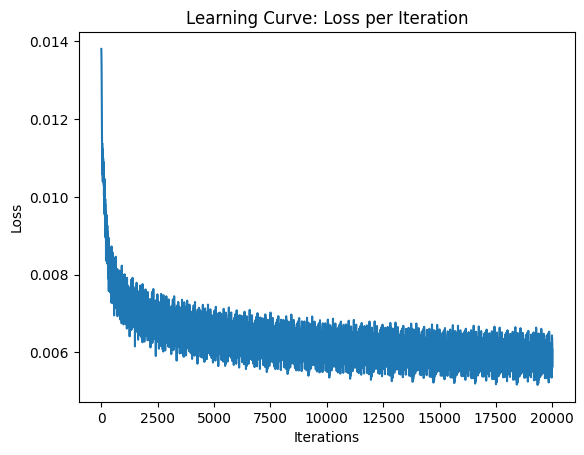

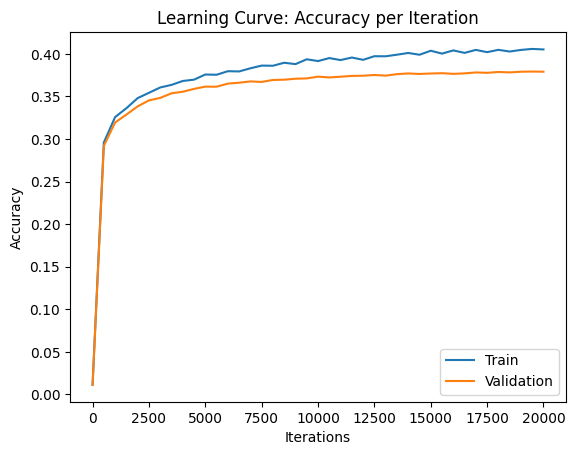

In [144]:
class PyTorchWordEmb(nn.Module): # No need to change this class at all
    def __init__(self):
        super(PyTorchWordEmb, self).__init__()
        emb_size=100
        num_hidden=300
        vocab_size=250
        self.word_emb_layer = nn.Linear(vocab_size, emb_size, bias=False)
        self.fc_layer1 = nn.Linear(emb_size * 3, num_hidden)
        self.fc_layer2 = nn.Linear(num_hidden, 250)
        self.num_hidden = num_hidden
        self.emb_size = emb_size
    def forward(self, inp):
        embeddings = torch.relu(self.word_emb_layer(inp))
        embeddings = embeddings.reshape([-1, self.emb_size * 3])
        hidden = torch.relu(self.fc_layer1(embeddings))
        return self.fc_layer2(hidden)

pytorch_wordemb= PyTorchWordEmb()

result = run_pytorch_gradient_descent(
    pytorch_wordemb,
    train_data=train4grams,            # Training 4-grams
    validation_data=valid4grams,      # Validation 4-grams
    batch_size=400,                   # Adjust batch size for better updates
    learning_rate=0.001,              # Experiment with learning rate for better convergence
    weight_decay=1e-7,                # Optional regularization
    max_iters=20000)                   # Enough iterations for accuracy improvement


plot_learning_curve(*result)

### 3.2 A Few Examples

Use the function `make_prediction` that you wrote earlier to predict what the next word should be in each of the following sentences:

- "You are a"
- "few companies show"
- "There are no"
- "yesterday i was"
- "the game had"
- "yesterday the federal"

How do these predictions compared to the previous model?

**Print** the output for all of these sentences using the new network and

Just like before, if you encounter overfitting,
train your model for more iterations, or change the hyperparameters in your
model. You may need to do this even if your training accuracy is >=38%.

In [145]:
print(make_prediction_torch(pytorch_wordemb, ['you', 'are', 'a']))
print(make_prediction_torch(pytorch_wordemb, ['few', 'companies', 'show']))
print(make_prediction_torch(pytorch_wordemb, ['there', 'are', 'no']))
print(make_prediction_torch(pytorch_wordemb, ['yesterday', 'i', 'was']))
print(make_prediction_torch(pytorch_wordemb, ['the', 'game', 'had']))
print(make_prediction_torch(pytorch_wordemb, ['yesterday', 'the', 'federal']))

['man']
['.']
['other']
['nt']
['to']
['government']


### 3.3 Save Model Weights

Run the code below to save the weights of your model. Make sure to submit the weights file to the moodle.

In [146]:
# This file will be saved in your drive
torch.save(pytorch_wordemb.state_dict(), drive_path+"emb_MLP_model.pk")

### 3.4 Test Your Accuracy

Check the test accuracy of your model

In [147]:
pytorch_wordemb.load_state_dict(torch.load(drive_path+"emb_MLP_model.pk",weights_only=True))
pytorch_wordemb.eval()  # Set the model to evaluation mode
test_acc = estimate_accuracy_torch(pytorch_wordemb, test4grams)
print(f'Test accuracy: {test_acc * 100 :.2f}%')

Test accuracy: 38.24%


## Question 4. Visualizing Word Embeddings

While training the `PyTorchMLP`, we trained the `word_emb_layer`, which takes a one-hot
representation of a word in our vocabulary, and returns a low-dimensional vector
representation of that word. In this question, we will explore these word embeddings, which are a key concept in natural language processing.

This question will not be graded yet you should still complete it.


### 4.1 Extracting the Embedding

The code below extracts the **weights** of the word embedding layer,
and converts the PyTorch tensor into an numpy array.
Explain why each *row* of `word_emb` contains the vector representing
of a word. For example `word_emb[vocab_stoi["any"],:]` contains the
vector representation of the word "any".

In [148]:
word_emb_weights = list(pytorch_wordemb.word_emb_layer.parameters())[0]
word_emb = word_emb_weights.detach().numpy().T
print(word_emb.shape)

(250, 100)


**Write your explanation here:**

### 4.2 Cosine Similarity

One interesting thing about these word embeddings is that distances
in these vector representations of words make some sense! To show this,
we have provided code below that computes the *cosine similarity* of
every pair of words in our vocabulary. This measure of similarity between vector ${\bf v}$ and ${\bf w}$ is defined as
   $$d_{\rm cos}({\bf v},{\bf w}) = \frac{{\bf v}^T{\bf w}}{||{\bf v}|| ||{\bf w}||}.$$  We also pre-scale the vectors to have a unit norm, using Numpy's `norm` method.

In [149]:
norms = np.linalg.norm(word_emb, axis=1)
word_emb_norm = (word_emb.T / norms).T
similarities = np.matmul(word_emb_norm, word_emb_norm.T)

# Some example distances. The first one should be larger than the second
print(similarities[vocab_stoi['any'], vocab_stoi['many']])
print(similarities[vocab_stoi['any'], vocab_stoi['government']])

0.17580059
0.11942811


<ipython-input-149-7ee94e0d16ee>:2: RuntimeWarning: divide by zero encountered in divide
  word_emb_norm = (word_emb.T / norms).T
<ipython-input-149-7ee94e0d16ee>:3: RuntimeWarning: invalid value encountered in matmul
  similarities = np.matmul(word_emb_norm, word_emb_norm.T)


Compute the 5 closest words to the following words:

- "four"
- "go"
- "what"
- "should"
- "school"
- "your"
- "yesterday"
- "not"

In [150]:
# Write your code here
# List of target words to compute similarities for
target_words = ["four", "go", "what", "should", "school", "your", "yesterday", "not"]

# Compute the 5 closest words for each target word
for target_word in target_words:
    target_index = vocab_stoi[target_word]  # Get the index of the target word

    # Get cosine similarities for the target word with all other words
    similarities_for_word = similarities[target_index]

    # Get the indices of the 5 most similar words (excluding itself)
    closest_indices = np.argsort(similarities_for_word)[-6:][::-1]  # Top 6 sorted in descending order
    closest_indices = [idx for idx in closest_indices if idx != target_index][:5]  # Exclude the target word itself

    # Convert indices back to words
    closest_words = [vocab_itos[idx] for idx in closest_indices]

    # Print the results
    print(f"The 5 closest words to '{target_word}' are: {closest_words}")


The 5 closest words to 'four' are: ['.', 'two', 'five', 'several', 'three']
The 5 closest words to 'go' are: ['.', 'going', 'come', 'business', 'off']
The 5 closest words to 'what' are: ['.', 'where', 'how', 'when', 'while']
The 5 closest words to 'should' are: ['.', 'could', 'may', 'can', 'might']
The 5 closest words to 'school' are: ['.', 'work', 'court', 'out', 'program']
The 5 closest words to 'your' are: ['.', 'their', 'our', 'my', 'its']
The 5 closest words to 'yesterday' are: ['.', 'today', 'game', 'while', 'though']
The 5 closest words to 'not' are: ['.', 'nt', 'never', 'being', 'under']


### 4.3 Visualizing the Embedding using dimensionality reductions

We can visualize the word embeddings by reducing the dimensionality of
the word vectors to 2D. There are many dimensionality reduction techniques
that we could use, and we will use an algorithm called t-SNE.
(You don’t need to know what this is for the assignment; we will cover it later in the course.)
Nearby points in this 2-D space are meant to correspond to nearby points
in the original, high-dimensional space.

The following code runs the t-SNE algorithm and plots the result.

Look at the plot and find at least two clusters of related words.

**Write** below for each cluster what is the commonality (if there is any) and if they make sense.

Note that there is randomness in the initialization of the t-SNE
algorithm. If you re-run this code, you may get a different image.
Please make sure to save the image in this notebook.

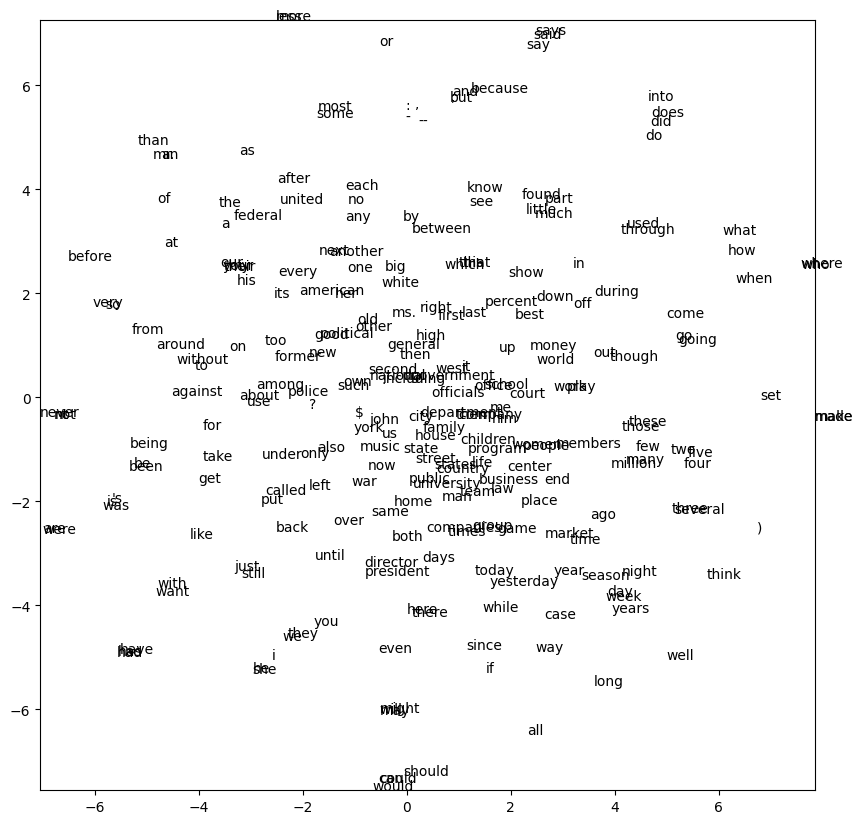

In [151]:
import sklearn.manifold
tsne = sklearn.manifold.TSNE()
Y = tsne.fit_transform(word_emb)

plt.figure(figsize=(10, 10))
plt.xlim(Y[:,0].min(), Y[:, 0].max())
plt.ylim(Y[:,1].min(), Y[:, 1].max())
for i, w in enumerate(vocab):
    plt.text(Y[i, 0], Y[i, 1], w)
plt.show()

**Explain and discuss your results here:**